In [3]:
%%HTML
<link rel="stylesheet" type="text/css" href="css/custom.css">

In [5]:
#main imports
import numpy as np
import pandas as pd 
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import dates
from datetime import timedelta

from sklearn.linear_model import LinearRegression

%matplotlib inline 

from fbprophet import Prophet

# About the speaker & Contact

**Vadim Nelidov**: [Data Scientist, Educator and Innovator at GoDataDriven](https://godatadriven.com/team/vadim-nelidov/)

Feel free to contact me via

*email*: vadimnelidov@godatadriven.com

*LinkedIn*: https://www.linkedin.com/in/vadim-nelidov-4b1921188


# Where to find the materials

Use this link to a dropbox folder :
https://gdd.li/ts_anomaly_webinar_materials

"*webinar_timeser_anomaly*" contains the slides

"*webinar_timeser_anomaly_supplementary*" contains the full code

# Anomaly detection in time series using Python


<img src="images/anomaly_logo.png" width="1050"/>


![footer_logo](images/logo.png)

# Program

- Anomaly detection in *time series* vs *unstructured data*
- Past vs future anomaly detection
- Rule-based approach
- Error-Trend-Seasonality decomposition
- Long-term forecasting models
- Short-term forecasting models
- What makes a good anomaly detection system

In [6]:
#loading the dataset
air_df = pd.read_csv('data/weekly_aqi.csv', index_col='date_local', parse_dates=True)
air_df.head()

,aqi
date_local,
2005-06-05,4.129268
2005-06-12,4.072525
2005-06-19,4.237064
2005-06-26,4.500022
2005-07-03,4.573794


# Anomaly detection in unstructured data


<img src="images/standard_anomalies.png" width="550" style="display: block;margin-left: auto;margin-right: auto;"/>


# Anomalies in time series (future)


<img src="images/future_anomaly.png"/>

(based on [air quality index dataset](https://www.kaggle.com/epa/carbon-monoxide), the lower - the better air quality)

# Anomalies in time series (past)


<img src="images/past_anomaly.png"/>



# Anomalies in time series

**Key distinctions**
- observations cannot be compared in abstraction from their timing
- global vs local anomalies
- context and neighborhoods become extra important
- many traditional unsupervised algorithms are inapplicable
- → need for different approaches to anomaly detection!

# Rule-based approach

- simple heuristics and 'rules of thumb' used to identify anomalies
- relying on certain thresholds or reference points
- comparisons to the past season(s) to acknowledge seasonality
- usually do not rely on forecasting models

# Rule-based approach
## Alarm if exceeding historic extremes
(exceeding cumulative 80% quantiles after year 1)

<img src="images/rule_based1.png"/>

In [ ]:
#implementation in Python (using Pandas)

(
    air_df
    .assign(quantile80 = lambda df: df.expanding()['aqi'].quantile(.8),
            alarm = lambda df: np.where((df['aqi'] > df['quantile80']), True, False))
)

# Rule-based approach
## Alarm if substantially different from past seasonal values
(more than 10% above last year's weekly value)

<img src="images/rule_based2.png"/>

In [ ]:
(
    air_df
    .assign(alarm = lambda df: np.where((df['aqi'] > 1.1 * df['aqi'].shift(52)), True, False))
)

# Rule-based approach
## Alarm if substantially different from the previous week
(more than 10% above last week's value)

<img src="images/rule_based3.png"/>

In [ ]:
(
    air_df
    .assign(alarm = lambda df: np.where((df['aqi'] > 1.1 * df['aqi'].shift(1)), True, False))
)

# Rule-based approach
## Alarm if substantially different from seasonal monthly averages
(more than 10% above seasonal monthly value)

<img src="images/rule_based4.png"/>

# Rule-based approach

**Pros**
- simple, intuitive and explainable
- computationally cheap and does not require explicit modeling / forecasting

**Cons**
- mostly inflexible, arbitrary and subject to difficult trade-offs
- usually not robust to very dynamic patterns
- may treat repetitive anomalous behavior as normal

That said, having a few meaningful conservative rule-based detectors is usually a good idea. (e.g. for server capacity or other limited resources)


# Error-Trend-Seasonality decomposition for anomaly detection

**Decomposition models**
- make abnormal variation much more apparent by explicitly removing correlated components (seasonality & trend) 
- allow us to directly inspect the remaining residuals and apply a variety of statistical tests on them 
- original attributes of the anomalies at the same time remain preserved

**Implementation:**
While this approach can be taken with any model that explicitly models seasonality and trend, a common approach is to use `seasonal_decompose` algorithm from `statsmodels` library.

# Error-Trend-Seasonality decomposition for anomaly detection


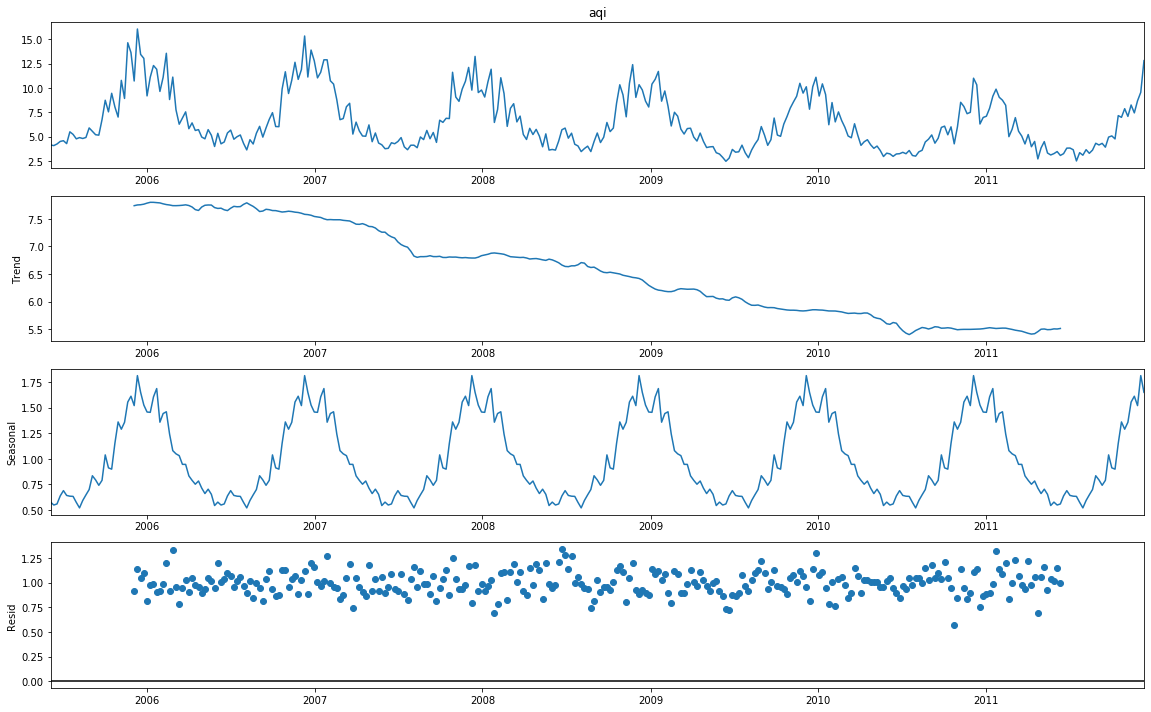

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
Decomposition = seasonal_decompose(air_df['aqi'].loc[:'2011-12-15'], model='multiplicative')  #or model='additive' 

with plt.rc_context():
    plt.rc("figure", figsize=(16,10))
    Decomposition.plot();

Fitted n-dist parameters are: mu=1.000, std=0.124


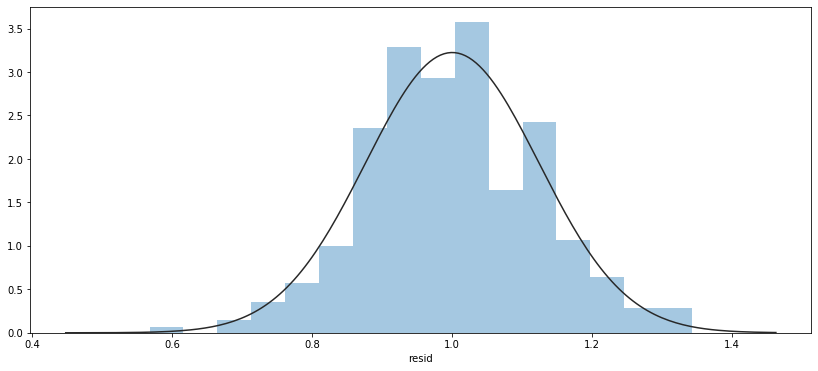

In [9]:
from scipy import stats
fig, ax = plt.subplots(figsize=(14,6))

# Fit a normal distribution to the residuals:
mu, std = stats.norm.fit(Decomposition.resid[~np.isnan(Decomposition.resid)])
print(f"Fitted n-dist parameters are: mu={mu:.3f}, std={std:.3f}")

sns.distplot(Decomposition.resid, fit=stats.norm, kde=False, ax=ax);

# ETS decomposition for anomaly detection
## Finding values outside of 2 std from mu (5% probability)

<img src="images/resid_outlier.png"/>

# ETS decomposition for anomaly detection
## Marking found outliers on the time series

<img src="images/resid_outlier_combined.png"/>

# ETS decomposition for anomaly detection

**Pros**
- robust to past anomalies
- focus on unexplainable variability
- permits conventional statistical testing

**Cons**
- Inappropriate decompositions result in immediate errors
- May work less well with very noisy data
- Limited explainability for some ETS filters

# Using long-term forecasting models

- a good forecasting model can capture what should normally be expected from a time series now and in the future
- we can then work with this notion of 'normality' to find anomalies e.g. using confidence intervals

**Choosing a forecasting model:**
- there are many possibilities but we should avoid overfitting models (more on that later)
- high bias low variance models might work better for our purpose
- we could create a seasonality model from scratch for forecasting (see my [previous talk](https://youtu.be/omEVdUS14SU))
- we can also make use of existing powerful libraries such as [Prophet](https://facebook.github.io/prophet/)


# Using long-term forecasting models (Prophet)

Prophet model explicitly models trends, seasonality and holiday effects, while being robust to missing data, outliers and dramatic changes as well as outperforming many other forecasting models.

<img src="images/prophet1.png"/>

In [ ]:
#prophet forecasting in Python
model = Prophet(seasonality_mode='multiplicative')
model.fit(air_pr_train)

future = model.make_future_dataframe(periods=53, freq='W') 
forecast = model.predict(future)

fig, ax = plt.subplots(figsize=(18,7))
model.plot(forecast, ax=ax)

# Using long-term forecasting models (Prophet)

Future values outside confidence bounds can be flagged as anomalies. We can also apply this principle for retrospective anomaly detection.
<img src="images/prophet2.png"/>

*RMSE*: 1.64, 28.0% of the test set average (measure of forecast quality)

*Exercise:* acquire Prophet's residuals (as *y_hat - y_real*) and repeat the method that we used for ETC decompositions previously.

# Using long-term forecasting models

**Pros**
- robust and reliable provided a good model implementation
- interpretable and provide us with a representation of "normality"
- usable for both 1-period and multi-period anomaly detection
- often can be combined with ETS decomposition approach

**Cons**
- Failure to recognize dynamics correctly leads to consistently wrong detection
- Works less well with less structured time series -> ARIMA etc may work better

# Using short-term forecasting models

- We do not always have the privilege to capture stable long-term patterns
- As an alternative, we can also use short-term forecasting (with e.g. ARIMA or LSTMs)
- These models can be quite powerful for forecasting (especially in highly irregular data)
- Besides these are already a common choice for forecasting models in production
- They might not always be the best choice for anomaly detection though

Let's see an LSTM in practice that at each point uses 4 weeks data to predict the 5th week

# Using short-term forecasting models

Even though LSTM's forecast may be occasionally closer to unexpected local fluctuations, it is mainly chasing the noise.

<img src="images/lstm1.png"/>

*RMSE*: 1.17, 20.0% of the test set average (seemingly better than with Prophet)

# Using short-term forecasting models

As a result of low confidence and predictions that are "catching" actual values, we find almost no anomalies. A shortsighted & overfitting model may not be the best choice for anomaly detection

<img src="images/lstm2.png"/>

# Using short-term forecasting models

**Pros**
- May be more appropriate when we deal with highly volatile and unpredictable data
- Might be the only choice in times of shocks and crises
- Flexible and can work with very unusual time series


**Cons**
- Tend to overfit on the training data and fail to recognize new unique anomalies
- "Catching" actual values results in "anomaly acceptance"
- Mostly deal with "local normality"
- Usually are much less interpretable
- Often require lots of ambiguous fine-tuning

# What makes a good anomaly detection system

**achieve:**

- Minimizing false positives
- Robustness to past anomalies
- Seeing the big and not just the local picture
- Distinguishing mild and extreme anomalies
- Anomalies should be explainable


**avoid:**
- only identifying anomalies seen during training
- combining forecasting and anomaly models when it hurts
- blindly trusting complex models

# Tips for success

- Combine simple meaningful rules with advanced techniques
- Use results of multiple systems to minimize false alarms
- Validate your anomaly detection systems
(e.g. cross-validation on the past data)
- Respond differently to different anomalies
- Use complementary data for checks and insights
- Keep historic record of actual occurred anomalies
- Also use common sense to evaluate anomaly detection





# Thank you for your attention!

<img src="images/thanks.png" width="500" style="display: block;margin-left: auto;margin-right: auto;"/>